In [1]:
# ------------------------------------------------------------------------------------------------------------------------------------------------------------
# Data Handling and Processing
import numpy as np
import pandas as pd
import math
from sklearn.impute import KNNImputer
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, PowerTransformer
from sklearn.base import BaseEstimator, TransformerMixin
# ------------------------------------------------------------------------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------------------------------------------------------------------------
# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
import viztools as viz
import mlTools as mt
# ------------------------------------------------------------------------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------------------------------------------------------------------------
# Model Selection, Metrics & Evaluation
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
# ------------------------------------------------------------------------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------------------------------------------------------------------------
# Pipeline Construction 
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# ------------------------------------------------------------------------------------------------------------------------------------------------------------

---
---
## Load train and prediction set

In [ ]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

print('-'*16)
print(f'Train Set Shape:\n{train.shape}')
print('-'*16)
print(f'Test Set Shape:\n{test.shape}')
print('-'*16)

----------------
Train Set Shape:
(8693, 14)
----------------
Test Set Shape:
(4277, 13)
----------------


---
---
## Define functions for:
- cross-validation of the training set using balanced accuracy, F1 and ROC-AUC scores
- evaluating model against validation set with options to:
    - print a full classification report
    - display a confusion matrix

In [91]:
def cv_evaluate(model, X, y, print_scores=False):
    
    scoring = ['balanced_accuracy','f1','roc_auc']
    results = cross_validate(model, X, y, cv=5, scoring=scoring, return_train_score=False)

    balanced_acc = np.mean(results['test_balanced_accuracy'])
    f1_score = np.mean(results['test_f1'])
    roc_auc = np.mean(results['test_roc_auc'])
    if print_scores:
        print(f'Mean Cross Validation Scores for {model.__class__.__name__}:\n{"-"*21}')
        print(f'Balanced accuracy: {balanced_acc:.5f}')
        print(f'F1: {f1_score:.5f}')
        print(f'ROC_AUC: {roc_auc:.5f}') 
    return balanced_acc, f1_score, roc_auc

def fit_test_evaluate(model, X_train, y_train, X_test, y_test, get_report=False, get_confusion=False):
    model.fit(X_train, y_train)
    y_preds = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_preds)
    f1 = f1_score(y_test, y_preds)
    
    print(f'Test Scores:\n{"-"*12}')
    print(f'Test data accuracy Score: {accuracy:.5f}')
    print(f'Test data f1 score: {f1:.5f}\n')

    if get_report:
        print(f'Classification Report:\n{"-"*22}')
        print(classification_report(y_test, y_preds))
    if get_confusion:
        print(f'Confusion Matrix:\n{"-"*17}')
        ConfusionMatrixDisplay.from_predictions(y_test, y_preds)
    return None

---
---
## Define custom classes to handle data processing

In [2]:
# Transform PassengerId into InGroup and GroupSize
class TransformPassengerId(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        X['GroupId'] = X['PassengerId'].str.split('_').str[0]
        X['PassengerNumber'] = X['PassengerId'].str.split('_').str[1].astype(float)
        group_counts = X['GroupId'].value_counts()
        X['GroupSize'] = X['GroupId'].map(group_counts)
        X['InGroup'] = np.where(X['GroupSize'] > 1, 1, 0)
        return X


# Transform Cabin into Deck, CabinPosition and Side 
class TransformCabin(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        X['Deck'] = X['Cabin'].str.split('/').str[0]
        X['CabinNumber'] = X['Cabin'].str.split('/').str[1].astype(float)
        X['Side'] = X['Cabin'].str.split('/').str[2]
        bin_edges = np.linspace(X['CabinNumber'].min(), X['CabinNumber'].max(), 5)
        X['CabinPosition'] = pd.cut(X['CabinNumber'],
                                    bins=bin_edges,
                                    labels=['Front','Second','Third','Back'],
                                    include_lowest=True)
        return X


# Impute HomePlanet
class ImputeHomePlanet(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        group_modes = X.groupby('GroupId')['HomePlanet'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
        X.loc[X['HomePlanet'].isna(), 'HomePlanet'] = group_modes[X['HomePlanet'].isna()]

        deck_modes = X.groupby('Deck')['HomePlanet'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
        X.loc[X['HomePlanet'].isna(), 'HomePlanet'] = deck_modes[X['HomePlanet'].isna()]

        if 'VIP' in X.columns:
            vip_mode_homePlanet = X.loc[X['VIP'] == True, 'HomePlanet'].mode().iloc[0]
            X.loc[X['VIP'] & X['HomePlanet'].isna(), 'HomePlanet'] = vip_mode_homePlanet

        X['HomePlanet'].fillna(X['HomePlanet'].mode().iloc[0], inplace=True)

        return X


# Create proportional imputer and impute
class ProportionalImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        impute_cols = ['Destination', 'Deck', 'Side', 'CabinPosition', 'VIP', 'CryoSleep']
        for col in impute_cols:
            proportions = X.groupby('HomePlanet')[col].value_counts(normalize=True)

            def impute_values(row):
                if pd.isna(row[col]):
                    group = row['HomePlanet']
                    if pd.notna(group) and group in proportions.index:
                        group_proportions = proportions.loc[group].dropna()
                        return np.random.choice(group_proportions.index, p=group_proportions.values)
                return row[col]
        
            X[col] = X.apply(impute_values, axis=1)
        return X


# KNN Imputer and transformer
class KNNImputerTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.columns = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
        self.imputer = KNNImputer(n_neighbors=5)
        self.imputer.fit(X[self.columns])
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        X[self.columns] = self.imputer.transform(X[self.columns])
        return X


# Create TotalSpent column
class CreateTotalSpent(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        X['TotalSpent'] = X[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum(axis=1)
        return X


# Convert binary classes to int 
class ToInt(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        cols = ['InGroup', 'CryoSleep', 'VIP', 'Transported']
        for col in cols:
            if col in X.columns:
                X[col] = X[col].astype(int)
        return X


# Drop unwanted columns
class DropColumns(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        droppers = ['PassengerNumber', 'GroupId', 'Cabin', 'CabinNumber', 'Name']
        X.drop(columns=droppers, inplace=True, errors='ignore')
        return X

---
---
## Split train into X, y pairs and train, validation sets

In [4]:
target = 'Transported'

train = shuffle(train, random_state=42)
train, val = train_test_split(train, test_size=0.3, stratify=train[target], random_state=42)

X_train, y_train = train.drop(target, axis=1), train[target]
X_val, y_val = val.drop(target, axis=1), val[target]

---
---
## Instantiate base algorithms

Set up column lists for processing in pipeline

In [70]:
ohe_cols = ['HomePlanet','Destination','Deck','Side','CabinPosition','InGroup','VIP','CryoSleep','GroupSize']
scaler_cols = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','TotalSpent']

Base algorithms

In [89]:
lr = LogisticRegression(C=1, max_iter=1000)
svc = SVC(C=1, kernel='sigmoid', gamma='scale')

rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
lgbm = LGBMClassifier(n_estimators=100, max_depth=5, verbose=-1, random_state=42)
xgbm = XGBClassifier(n_estimators=100, max_depth=5, random_state=42)
catb = CatBoostClassifier(iterations=100, depth=5, cat_features=ohe_cols, l2_leaf_reg=2)

base_algs = {'lr':lr, 'svc':svc, 'rf':rf, 'lgbm':lgbm, 'xgbm':xgbm, 'catb':catb}

---
---
## Build base pipeline

***NOTE***:  
- A pipeline is probably more complicated that is necessary for this particular puzzle.
- However the use of a pipeline provides the best workflow to avoid data leakage from the training folds into the validation folds during cross validation.

In [85]:
preprocess = Pipeline([
    ('TransformPassengerId', TransformPassengerId()),
    ('TransformCabin', TransformCabin()),
    ('ImputeHomePlanet', ImputeHomePlanet()),
    ('ProportionalImputer', ProportionalImputer()),
    ('KNNImputer', KNNImputerTransformer()),
    ('CreateTotalSpent', CreateTotalSpent()),
    ('ToInt', ToInt()),
    ('DropColumns', DropColumns())
])

scaling = Pipeline([
    ('power', PowerTransformer(method='yeo-johnson')),
    ('scale', StandardScaler())
])

manipulator = ColumnTransformer(force_int_remainder_cols=False,
        transformers=[
                ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ohe_cols),
                ('transformScale', scaling, scaler_cols)],
                remainder = 'passthrough')

pipe = Pipeline([
    ('process', preprocess),
    ('mainpulate', manipulator),
    ('clf', base_algs['svc'])
])

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
feature_selection = RFE(estimator=RandomForestClassifier(), n_features_to_select=10)

Check pipeline works with

In [72]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('process',
                 Pipeline(steps=[('TransformPassengerId',
                                  TransformPassengerId()),
                                 ('TransformCabin', TransformCabin()),
                                 ('ImputeHomePlanet', ImputeHomePlanet()),
                                 ('ProportionalImputer', ProportionalImputer()),
                                 ('KNNImputer', KNNImputerTransformer()),
                                 ('CreateTotalSpent', CreateTotalSpent()),
                                 ('ToInt', ToInt()),
                                 ('DropColumns', DropColumns())])),
                ('mainp...
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['HomePlanet', 'Destination',
                                                   'Deck', 'Side',
                                                   'CabinPosition', 'InGroup',
                                                   'VIP', 'CryoSleep',
                                                   'GroupSize']),
                                                 ('transformScale',
                                                  Pipeline(steps=[('power',
                                                                   PowerTransformer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck',
                                                   'TotalSpent'])])),
                ('clf', SVC(C=1, kernel='sigmoid'))])

In [ ]:
cv_evaluate(pipe, X_train, y_train, print_scores=True)

---
---
## Cross validate all base algorithms on test data

***Metrics***:
- Balanced accuracy
- F1 score
- ROC-AUC

In [92]:
models = []
balanced_accs = []
f1_scores = []
roc_auc_scores = []

for name, alg in base_algs.items():
    if name != 'catb':
        pipe = Pipeline([
            ('process', preprocess),
            ('mainpulate', manipulator),
            ('clf', alg)
        ])

        balanced_acc, f1, roc_auc = cv_evaluate(pipe, X_train, y_train)

        models.append(name)
        balanced_accs.append(balanced_acc)
        f1_scores.append(f1)
        roc_auc_scores.append(roc_auc)

cross_val_df = pd.DataFrame({
    'Model': models,
    'Balanced Accuracy': balanced_accs,
    'F1 Score': f1_scores,
    'ROC-AUC': roc_auc_scores
})

cross_val_df

,Model,Balanced Accuracy,F1 Score,ROC-AUC
0,lr,0.753885,0.753045,0.831321
1,svc,0.502068,0.502747,0.505785
2,rf,0.805135,0.805119,0.889044
3,lgbm,0.804514,0.807961,0.900737
4,xgbm,0.803616,0.804767,0.896958


Test Scores:
------------
Test data accuracy Score: 0.78719
Test data f1 score: 0.79017

Classification Report:
----------------------
              precision    recall  f1-score   support

       False       0.79      0.78      0.78      1295
        True       0.78      0.80      0.79      1313

    accuracy                           0.79      2608
   macro avg       0.79      0.79      0.79      2608
weighted avg       0.79      0.79      0.79      2608

Confusion Matrix:
-----------------


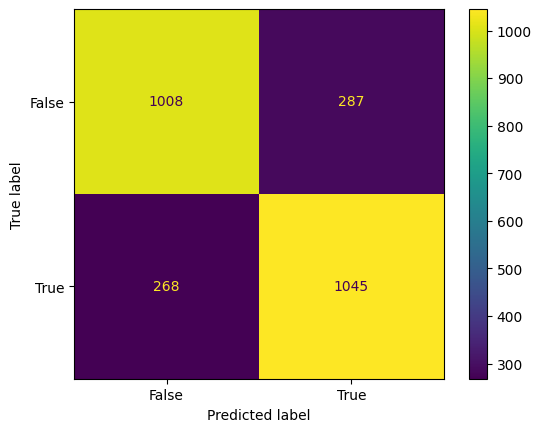

In [68]:
fit_test_evaluate(pipe, X_train, y_train, X_val, y_val, get_report=True, get_confusion=True)